# Domain decomposition

Rectangles are great and all, but we might like to go beyond them. One attractive technique that generalizes the geometry somewhat is **domain decomposition**. It can also break a large problem into smaller pieces that are more manageable and perhaps solvable in parallel.

There are two major types of domain decomposition.

## Nonoverlapping

In a nonoverlapping DD method, domain $\Omega$ is broken into $\Omega_i$ that intersect only at lower-dimensional interfaces. 

For simplicity, consider a domain with two subregions $\Omega_1$ and $\Omega_2$, with $\Gamma_i = \partial \Omega_i \cap \partial \Omega$ and $\Gamma_{12} = \partial \Omega_1 \cap \partial \Omega_2$. You can imagine that both $\Omega_i$ are rectangles in practice, but this is not important in principle. It can be shown that the solution of 

$$
\Delta u &= 0, \quad \text{in } \Omega, \\ 
Bu &= 0, \quad \text{on } \partial \Omega, 
$$

where $B$ is a linear operator of differential order 0 or 1, is equivalent to the solution of the subproblems

$$
\Delta u_i &= 0, \quad \text{in } \Omega_i, \\ 
Bu_i &= 0, \quad \text{on } \Gamma_i,  
$$

coupled by the **interface conditions** 

$$
u_1 = u_2, \quad \pp{u_1}{n} = -\pp{u_2}{n}, \qquad \text{on }  \Gamma_{12}.
$$

Now let us discretize the subregions. The equations for the non-interface nodes of $\Omega_1$ have the form

$$
\begin{bmatrix}
  \bfA_{1o} & \bfA_{1i}
\end{bmatrix}
\begin{bmatrix}
  bfu_{1o} \\ \bfu_{1i}
\end{bmatrix}
= \bfb_1, 
$$

where we have partitioned into ordinary/interface nodes. Doing similarly for $\Omega_2$ and adding the interface conditions gives

$$
\begin{bmatrix}
  \bfA_{1o} & & \bfA_{1i} & \\ 
  & \bfA_{2o} & & \bfA_{2i} \\ 
  & & & \mathbf{I} & -\mathbf{I} \\ 
  & & \bfD_{n1} & \bfD_{n2}
\end{bmatrix}
\begin{bmatrix}
  bfu_{1o} \\ \bfu_{2o} \\ \bfu_{1i} \\ \bfu_{2i}
\end{bmatrix}
= 
\begin{bmatrix}
  \bfb_1 \\ \bfb_2 \\ \bfzero \\ \bfzero 
\end{bmatrix}. 
$$

In [1]:
using LinearAlgebra
⊗ = kron
include("diffmats.jl")

n = 8
R₁ = (nx=n,xspan=(-1,0),ny=2n,yspan=(-1,1))
R₂ = (nx=n,xspan=(0,1),ny=n,yspan=(-1,0)) 

f(x) = x[1]+2

function isboundary(xy)
    x,y = xy
    return (x==-1) | (x==1) | (y==-1) | (y==1) | 
        ((x==0) & (y>=0)) | ((y==0) & (x>=0))
end

function isinterface(xy)
    return ((xy[1]==0) & (-1<xy[2]<0))
end

region = []
for R in (R₁,R₂)
    nx,ny = R.nx,R.ny
    x,Dx,Dxx = diffmats(R.nx,R.xspan...)
    y,Dy,Dyy = diffmats(R.ny,R.yspan...)
    N = (nx+1)*(ny+1)
    Δ = I(ny+1)⊗Dxx + Dyy'⊗I(nx+1)
    grid = vec([[x,y] for x in x, y in y])
    onbdy = isboundary.(grid)
    oniface = isinterface.(grid)
    interior = @. !onbdy & !oniface
    Dnorm = (I(ny+1)⊗Dx)[oniface,:]
    push!(region,(;x,y,nx,ny,N,Δ,grid,onbdy,oniface,interior,Dnorm))
end

In [2]:
points = [region[1].grid;region[2].grid]
offset = [0,region[1].N]
idx = []
for (k,r) in zip(offset,region)
    all = k.+(1:r.N)
    iface = k.+findall(r.oniface)
    bdy = k.+findall(r.onbdy)
    push!(idx,(;all,iface,bdy))
end

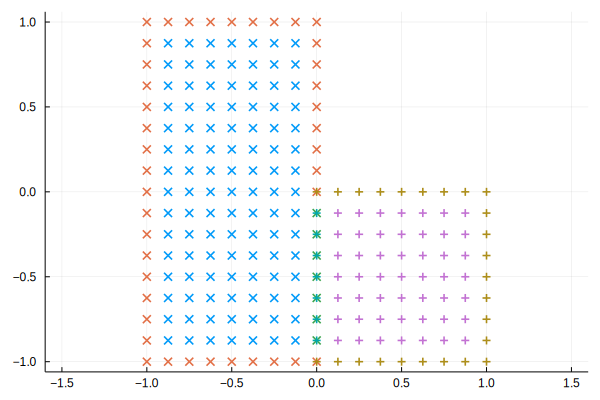

In [3]:
using Plots
fig = plot(aspect_ratio=1,m=3,leg=false)
for (i,r,sym) in zip(idx,region,[:x,:+])
    for s in [r.interior,r.onbdy,r.oniface]
        x,y = [p[1] for p in r.grid[s]],[p[2] for p in r.grid[s]]
        scatter!(x,y,m=sym,msw=2)
    end
end
fig

In [4]:
N = sum(r.N for r in region)
A = sparse(zeros(N,N))
b = zeros(N)
for (i,r) in zip(idx,region)
    A[i.all,i.all] = r.Δ
    b[i.all] = f.(r.grid)
    A[i.bdy,:] .= 0
    A[i.bdy,i.bdy] .= diagm(ones(length(i.bdy)))
    b[i.bdy] .= 0
end

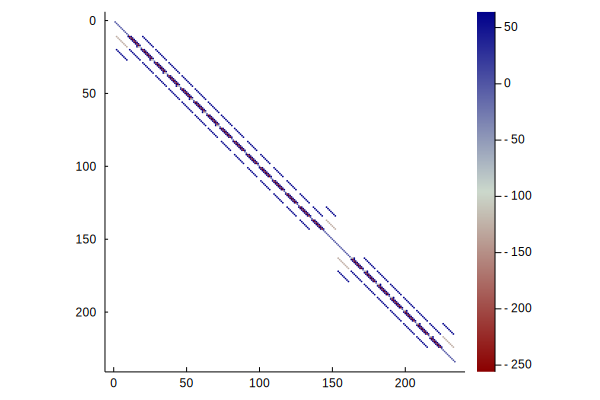

In [5]:
spy(A,color=:redsblues)

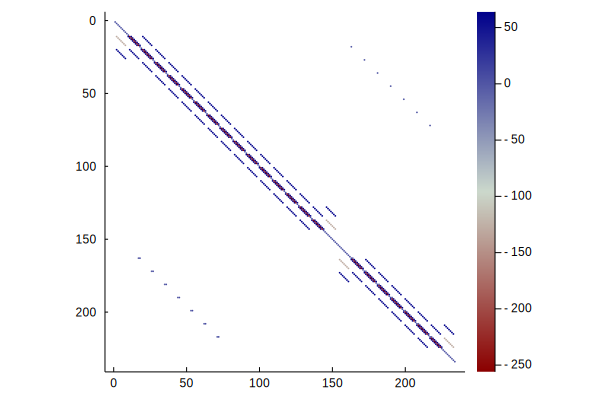

In [6]:
Ni = length(idx[1].iface)
A[idx[1].iface,:] .= 0
A[idx[1].iface,idx[1].iface] = spdiagm(ones(Ni))
A[idx[1].iface,idx[2].iface] = -spdiagm(ones(Ni))
b[idx[1].iface] .= 0

A[idx[2].iface,:] .= 0
A[idx[2].iface,idx[1].all] = region[1].Dnorm
A[idx[2].iface,idx[2].all] = -region[2].Dnorm
b[idx[2].iface] .= 0
spy(A,color=:redsblues)

In [7]:
u = A\b;

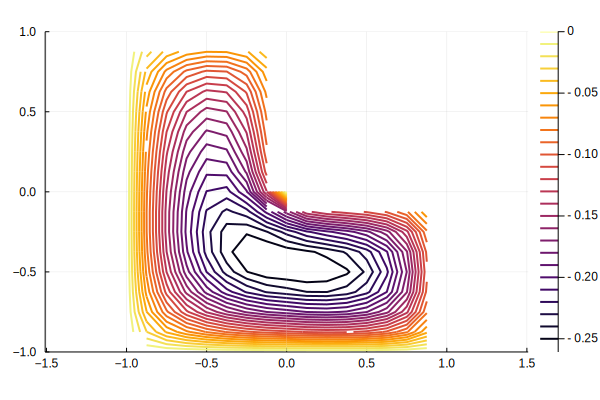

In [8]:
gr()
plt = plot(aspect_ratio=1)
for (i,r) in zip(idx,region)
    contour!(r.x,r.y,u[i.all],levels=-.25:0.01:0)
end
plt

We could again use the Schur complementation technique to remove the interface unknowns from the linear system. 

## Overlapping

A more versatile technique is to use overlapping subdomains. The two subdomains $\Omega_1$ and $\Omega_2$ still have the true boundaries $\Gamma_i = \partial \Omega_i \cap \partial \Omega$, but now we let 

$$
\tilde{\Gamma}_{1} = \partial \Omega_1 \cap \Omega_2, \quad \tilde{\Gamma}_{2} = \partial \Omega_1 \cap \Omega_1. 
$$

This decomposes $\partial \Omega_i$ as $\Gamma_i \cup \tilde{\Gamma}_i$ in nonintersecting fashion. Now the solution of the global problem 

$$
\Delta u &= 0, \quad \text{in } \Omega, \\ 
Bu &= 0, \quad \text{on } \partial \Omega, 
$$

is equivalent to the solution of the subproblems

$$
\Delta u_i &= 0, \quad \text{in } \Omega_i, \\ 
B u_i &= 0, \quad \text{on } \Gamma_i,  
u_i &= P_i u_{3-i}, \quad \text{on } \tilde{Gamma}_i,
$$

where $P_i$ represents the projection, say by interpolation, of a function defined in $\Omega_{3-i}$ into one defined on $\tilde{\Gamma}_i$. That is, a subsolution on one subdomain must agree with the other subsolution on the part of its boundary that lies inside the other subdomain. Note that no normal derivative (Neumann condition) is required. This formulation is straightforward to generalize to more than two overlapping subdomains.

The classical **Schwarz alternating method** (technically, *multiplicative* Schwarz) is to seek a fixed point of the new formulation solving alternately on the subdomains, each time pulling its boundary information from the most recent solution(s) on the other subdomain(s). Often we might prefer the *additive* form, in which the subdomain problems are all solved simultaneously with the "previous generation" of subsolutions. This gives an algorithm of the form parallel solve, communicate via interfaces, parallel solve, etc.

While the Schwarz methods make it easy to parallelize the solution process and give some global geometric flexibility, the overlap regions are doubly discretized, which is in some sense wasteful. Furthermore, the convergence rate of the process degrades as the amount of overlap decreases, and when a large number of subdomains is used, there needs to be a coarse global discretization in order to speed up communication between distant parts of the domain. The method is frequently used as a preconditioner in an iterative solution of the global problem.


<!--

```{code-cell}
using LinearAlgebra
⊗ = kron
include("diffmats.jl")

n = 8
R = [ 
    (nx=n,xspan=(-1,0),ny=2n,yspan=(-1,1)),
    (nx=n,xspan=(-0.23,1),ny=n,yspan=(-1,0))
    ]

f(x) = x[1]+2

function isboundary(xy)
    x,y = xy
    return (x==-1) | (x==1) | (y==-1) | (y==1) | 
        ((x==0) & (y>=0)) | ((y==0) & (x>=0))
end

function isinside(xy,xspan,yspan)
    x,y = xy
    return (xspan[1] < x < xspan[2]) && (yspan[1] < y < yspan[2])
end

function isinterface(xy)
    return ((xy[1]==0) & (-1<xy[2]<0))
end
```

```{code-cell}
region = []
for i in 1:2
    nx,ny = R[i].nx,R[i].ny
    x,Dx,Dxx = diffmats(R[i].nx,R[i].xspan...)
    y,Dy,Dyy = diffmats(R[i].ny,R[i].yspan...)
    N = (nx+1)*(ny+1)
    Δ = I(ny+1)⊗Dxx + Dyy'⊗I(nx+1)
    grid = [[x,y] for x in x, y in y]
    interior = falses(nx+1,ny+1)
    interior[2:nx,2:ny] .= true
    oniface = .!interior
    otherR = R[3-i]
    for idx in findall(oniface)
        if !isinside(grid[idx],otherR.xspan,otherR.yspan)
            oniface[idx] = false
        end
    end
    onbdy = isboundary.(grid)
    push!(region,(;x,y,nx,ny,N,Δ,grid,onbdy,oniface,interior))
end
```

```{code-cell}
using Plots
fig = plot(aspect_ratio=1,m=3,leg=false)
for (r,sym) in zip(region,[:x,:+])
    for s in [r.interior,r.onbdy,r.oniface]
        x,y = [p[1] for p in r.grid[s]],[p[2] for p in r.grid[s]]
        scatter!(x,y,m=sym,msw=2)
    end
end
fig
```

```{code-cell}
u = [zeros(region[1].N),zeros(region[2].N)  ]
A = region[1].Δ
b = zeros(region[1].N)

for idx in findall(vec(region[1].onbdy))
    b[idx] = f(region[1].grid[idx])
    A[idx,:] .= 0
    A[idx,idx] = 1
end

for idx in findall(vec(region[1].oniface))
    b[idx] = u[2]region[1].grid[idx])
    A[idx,:] .= 0
    A[idx,idx] = 1
end


```

```{code-cell}
f.(region[1].grid[idx])
```

```{code-cell}
size(A),size(b)
```
-->